# Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, stft
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, Model, constraints
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization, Activation, AveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.constraints import max_norm

import os
import gc
from glob import glob
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_recall_fscore_support, classification_report

# Load dataset

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_parquet("drive/My Drive/eeg_parquet/co2a0000364.parquet")

df

,trial,sample,value,channel,subject,class,matching_condition,time
0,0,0,-8.921,FP1,co2a0000364,a,S1 obj,0.000000
1,0,1,-8.433,FP1,co2a0000364,a,S1 obj,0.003906
2,0,2,-2.574,FP1,co2a0000364,a,S1 obj,0.007812
3,0,3,5.239,FP1,co2a0000364,a,S1 obj,0.011719
4,0,4,11.587,FP1,co2a0000364,a,S1 obj,0.015625
...,...,...,...,...,...,...,...,...
1441787,119,251,-9.145,Y,co2a0000364,a,S2 match,0.980469
1441788,119,252,-10.610,Y,co2a0000364,a,S2 match,0.984375
1441789,119,253,-8.657,Y,co2a0000364,a,S2 match,0.988281
1441790,119,254,-4.751,Y,co2a0000364,a,S2 match,0.992188


# Peek dataset

In [4]:
# Find the generated .parquet files
parquet_files = sorted(glob('drive/My Drive/eeg_parquet/*.parquet'))


# Print the last 3 files
for i, file in enumerate(parquet_files[-3:]):
    print(f"\n📂 File {i+1}: {file}")
    df = pd.read_parquet(file)
    print(df.head())
    print(f"Total records: {df.shape[0]}")
    print("-" * 60)


📂 File 1: drive/My Drive/eeg_parquet/co3a0000460.parquet
   trial  sample  value channel      subject class matching_condition  \
0      0       0 -4.639     FP1  co3a0000460     a             S1 obj   
1      0       1 -4.639     FP1  co3a0000460     a             S1 obj   
2      0       2 -3.662     FP1  co3a0000460     a             S1 obj   
3      0       3 -2.197     FP1  co3a0000460     a             S1 obj   
4      0       4 -1.709     FP1  co3a0000460     a             S1 obj   

       time  
0  0.000000  
1  0.003906  
2  0.007812  
3  0.011719  
4  0.015625  
Total records: 1900544
------------------------------------------------------------

📂 File 2: drive/My Drive/eeg_parquet/co3a0000461.parquet
   trial  sample  value channel      subject class matching_condition  \
0      0       0  3.174     FP1  co3a0000461     a             S1 obj   
1      0       1  1.709     FP1  co3a0000461     a             S1 obj   
2      0       2 -0.244     FP1  co3a0000461     a        

In [5]:
for file in parquet_files[:5]:
    df = pd.read_parquet(file)
    print(f"\n{file}")
    print(f"Samples min={df['sample'].min()}, max={df['sample'].max()}")
    print(f"Values min={df['value'].min():.3f}, max={df['value'].max():.3f}")



drive/My Drive/eeg_parquet/co2a0000364.parquet
Samples min=0, max=255
Values min=-123.077, max=293.091

drive/My Drive/eeg_parquet/co2a0000365.parquet
Samples min=0, max=255
Values min=-153.290, max=236.847

drive/My Drive/eeg_parquet/co2a0000368.parquet
Samples min=0, max=255
Values min=-87.179, max=146.993

drive/My Drive/eeg_parquet/co2a0000369.parquet
Samples min=0, max=255
Values min=-160.126, max=172.923

drive/My Drive/eeg_parquet/co2a0000370.parquet
Samples min=0, max=255
Values min=-52.653, max=87.097


## Class distribution

In [6]:
subject_classes = {}

for file in parquet_files:
    df = pd.read_parquet(file)
    subj = df['subject'].iloc[0]
    subj_class = df['class'].iloc[0]
    subject_classes[subj] = subj_class

# Convert to dataframe to count
subjects_df = pd.DataFrame(list(subject_classes.items()), columns=['subject', 'class'])

print(subjects_df['class'].value_counts())

class
a    77
c    45
Name: count, dtype: int64


# Load and process data

### Utilities

In [7]:
def normalize_signal(signal: np.ndarray) -> np.ndarray:
    """Z-score normalization of a signal"""
    if np.std(signal) > 1e-8:
        return (signal - np.mean(signal)) / np.std(signal)
    return signal

def get_channel_signal(trial_data, ch, start_idx, win_size) -> np.ndarray:
    """Extracts a windowed signal from a channel with padding if necessary"""
    ch_data = trial_data[trial_data['channel'] == ch].sort_values('sample')
    if start_idx + win_size <= len(ch_data):
        return ch_data['value'].iloc[start_idx:start_idx + win_size].values

    available_signal = ch_data['value'].iloc[start_idx:].values
    if len(available_signal) == 0:
        return np.zeros(win_size)

    return np.pad(available_signal, (0, win_size - len(available_signal)), mode='constant')

def process_channel(signal, use_bands, channel_idx, sample) -> int:
    """Process one channel: extract frequency bands or raw signal"""
    if use_bands:
        bands = extract_frequency_bands(signal, fs=256)
        for band_name in ['raw', 'delta', 'theta', 'alpha', 'beta', 'gamma']:
            if band_name in bands:
                band_signal = normalize_signal(bands[band_name])
                sample[channel_idx, :, 0] = band_signal
            channel_idx += 1
    else:
        signal = normalize_signal(signal)
        sample[channel_idx, :, 0] = signal
        channel_idx += 1
    return channel_idx

def process_trial(trial_data, channels_to_use, win_size, step_size, use_bands, label, actual_n_channels):
    """Process one trial into EEGNet-ready samples"""
    samples = []
    channel_lengths = {
        ch: len(trial_data[trial_data['channel'] == ch]) for ch in channels_to_use
        if not trial_data[trial_data['channel'] == ch].empty
    }
    if not channel_lengths:
        return []

    min_length = min(channel_lengths.values())
    if min_length < win_size:
        return []

    n_windows = max(1, (min_length - win_size) // step_size + 1)
    for w in range(n_windows):
        start_idx = w * step_size
        sample = np.zeros((actual_n_channels, win_size, 1), dtype=np.float32)
        channel_idx, valid_channels_count = 0, 0

        for ch in channels_to_use:
            ch_data = trial_data[trial_data['channel'] == ch]
            if ch_data.empty:
                channel_idx += 6 if use_bands else 1
                continue

            signal = get_channel_signal(trial_data, ch, start_idx, win_size)
            channel_idx = process_channel(signal, use_bands, channel_idx, sample)
            valid_channels_count += 1

        if valid_channels_count > 0:
            samples.append((sample, label))
    return samples

def extract_frequency_bands(signal, fs=256):
    """Extract EEG frequency bands"""
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 50)
    }

    nyquist = fs / 2
    filtered_signals = {'raw': signal}

    for band_name, (low, high) in bands.items():
        try:
            low_norm = max(low / nyquist, 0.01)
            high_norm = min(high / nyquist, 0.99)

            b, a = butter(4, [low_norm, high_norm], btype='band')
            filtered = filtfilt(b, a, signal)
            filtered_signals[band_name] = filtered
        except:
            filtered_signals[band_name] = np.zeros_like(signal)

    return filtered_signals



### Processing

In [8]:
def load_eeg_data(parquet_files, channels, win_size=512, step_size=256,
                  use_bands=True, max_samples=None):
    """
    Load and process EEG data from parquet files
    Returns X, y arrays ready for EEGNet
    """
    X_data, y_data = [], []

    for pq_file in tqdm(parquet_files, desc="Loading data"):
        try:
            df = pd.read_parquet(pq_file)
            label = 1 if df['class'].iloc[0] == 'a' else 0
            trials = df['trial'].unique()

            available_channels = set(df['channel'].unique())
            requested_channels = set(channels)
            channels_to_use = list(requested_channels & available_channels)
            if not channels_to_use:
                print(f"Skipping {pq_file}: none of the requested channels available")
                continue

            actual_n_channels = len(channels_to_use) * 6 if use_bands else len(channels_to_use)

            for trial_id in trials:
                trial_data = df[df['trial'] == trial_id]
                samples = process_trial(trial_data, channels_to_use, win_size, step_size, use_bands, label, actual_n_channels)
                for s, y in samples:
                    X_data.append(s)
                    y_data.append(y)

                if max_samples and len(X_data) >= max_samples:
                    break

            del df
            gc.collect()
            if max_samples and len(X_data) >= max_samples:
                break

        except Exception as e:
            print(f"Error processing {pq_file}: {e}")
            import traceback; traceback.print_exc()
            continue

    if not X_data:
        print("ERROR: No samples were loaded!")
        return np.array([]), np.array([])

    X = np.array(X_data, dtype=np.float32)
    y = np.array(y_data, dtype=np.int32)

    print(f"\nLoaded {len(X)} samples")
    print(f"X shape: {X.shape}")
    print(f"y distribution: {np.bincount(y)}")

    return X, y

## Load data as x, y

In [10]:
def get_channels_from_file(parquet_file):
    """Get available channels from parquet file"""
    return [
    "F1", "F2", "F6", "FT7", "FT8", "FC3", "FC4", "FCZ",             # Frontal
    "O1", "O2",                                                      # Occipital
    "C1", "C2", "C3", "C4", "C5", "CP2", "CP3", "CP5", "CP6", "CPZ", # Central
    "AF7", "AF8",
    "P1", "P4", "P5", "P6", "P7", "P8", "PO1", "PO7", "O8",          # Parietal
    "T7", "T8", "TP7"
    ]

# Define path
data_dir = "/content/drive/MyDrive/eeg_parquet/"
all_parquets = sorted(glob(os.path.join(data_dir, "*.parquet")))

print(f"Found {len(all_parquets)} parquet files")

# Get channels
if all_parquets:
    channels = get_channels_from_file(all_parquets[0])
    print(f"Available channels ({len(channels)}): {channels}")
else:
    print("No parquet files found!")

# Load data
print("Loading EEG data...")
X, y = load_eeg_data(
    all_parquets,
    channels,
    win_size=256,
    step_size=256,
    use_bands=True
)

Found 122 parquet files
Available channels (34): ['F1', 'F2', 'F6', 'FT7', 'FT8', 'FC3', 'FC4', 'FCZ', 'O1', 'O2', 'C1', 'C2', 'C3', 'C4', 'C5', 'CP2', 'CP3', 'CP5', 'CP6', 'CPZ', 'AF7', 'AF8', 'P1', 'P4', 'P5', 'P6', 'P7', 'P8', 'PO1', 'PO7', 'O8', 'T7', 'T8', 'TP7']
Loading EEG data...


Loading data: 100%|██████████| 122/122 [1:17:14<00:00, 37.99s/it]



Loaded 11057 samples
X shape: (11057, 198, 256, 1)
y distribution: [4024 7033]


### Split dataset

In [11]:
def split_train_val_test(X, y, val_split=0.2, test_split=0.2):
    """Split data into train/val/test"""
    n_total = len(X)
    n_test = int(n_total * test_split)
    n_val = int(n_total * val_split)
    n_train = n_total - n_test - n_val

    # Shuffle indices
    indices = np.random.permutation(len(X))

    # Split indices
    test_idx = indices[:n_test]
    val_idx = indices[n_test:n_test + n_val]
    train_idx = indices[n_test + n_val:]

    # Create splits
    X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
    y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

    print(f"Train: {X_train.shape} ({len(y_train)} samples)")
    print(f"Val:   {X_val.shape} ({len(y_val)} samples)")
    print(f"Test:  {X_test.shape} ({len(y_test)} samples)")
    print(f"Train distribution: {np.bincount(y_train)}")
    print(f"Val distribution:   {np.bincount(y_val)}")
    print(f"Test distribution:  {np.bincount(y_test)}")

    return X_train, X_val, X_test, y_train, y_val, y_test

# Uso actualizado:
X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(
    X, y,
    val_split=0.2,   # 20% para validación
    test_split=0.2   # 20% para test
)

Train: (6635, 198, 256, 1) (6635 samples)
Val:   (2211, 198, 256, 1) (2211 samples)
Test:  (2211, 198, 256, 1) (2211 samples)
Train distribution: [2437 4198]
Val distribution:   [ 781 1430]
Test distribution:  [ 806 1405]


# Create and compile model

In [12]:
def create_eegnet(nb_classes=1, Chans=64, Samples=512, dropoutRate=0.5,
                  kernLength=64, F1=8, D=2, F2=16):
    """Create EEGNet model"""

    input_layer = Input(shape=(Chans, Samples, 1))

    # Block 1: Temporal convolution
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input_layer)
    block1 = BatchNormalization()(block1)

    # Depthwise convolution (spatial filtering)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False,
                            depth_multiplier=D,
                            depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)

    # Block 2: Separable convolution
    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(dropoutRate)(block2)

    # Classification
    flatten = Flatten()(block2)
    dense = Dense(nb_classes, kernel_constraint=max_norm(0.25))(flatten)
    output = Activation('sigmoid')(dense)

    model = Model(inputs=input_layer, outputs=output)
    return model


In [13]:
n_channels = X.shape[1]
model = create_eegnet(
    nb_classes=1,
    Chans=n_channels,
    Samples=256,
    dropoutRate=0.5
)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 198, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 198, 256, 8)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 198, 256, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 1, 256, 16)     │         3,168 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 256, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1, 256, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 64, 16)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 1, 64, 16)      │           512 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 64, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1, 64, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 1, 8, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,481 (17.50 KB)

 Trainable params: 4,401 (17.19 KB)

 Non-trainable params: 80 (320.00 B)

# Train

In [14]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc', patience=10, restore_best_weights=True,
        mode='max', verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc', factor=0.5, patience=5,
        mode='max', verbose=1, min_lr=1e-7
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras', monitor='val_auc', save_best_only=True,
        mode='max', verbose=1
    )
]

print("Starting training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

Starting training...
Epoch 1/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6434 - auc: 0.6126 - loss: 0.6495
Epoch 1: val_auc improved from -inf to 0.71662, saving model to best_model.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 605s 3s/step - accuracy: 0.6435 - auc: 0.6129 - loss: 0.6494 - val_accuracy: 0.6929 - val_auc: 0.7166 - val_loss: 0.6071 - learning_rate: 0.0010
Epoch 2/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7047 - auc: 0.7379 - loss: 0.5863
Epoch 2: val_auc improved from 0.71662 to 0.78749, saving model to best_model.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 602s 3s/step - accuracy: 0.7048 - auc: 0.7379 - loss: 0.5862 - val_accuracy: 0.7313 - val_auc: 0.7875 - val_loss: 0.5367 - learning_rate: 0.0010
Epoch 3/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7478 - auc: 0.8098 - loss: 0.5280
Epoch 3: val_auc improved from 0.78749 to 0.85350, saving model to best_model.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 626s 3s/step - accuracy: 0.7478 - auc: 0.8099 - loss: 0.

# Evaluate model

In [15]:
def plot_training_history(history):
    """Plot training history"""
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_title('Loss')
    axes[0].legend()

    # Accuracy
    axes[1].plot(history.history['accuracy'], label='Train Acc')
    axes[1].plot(history.history['val_accuracy'], label='Val Acc')
    axes[1].set_title('Accuracy')
    axes[1].legend()

    # AUC
    axes[2].plot(history.history['auc'], label='Train AUC')
    axes[2].plot(history.history['val_auc'], label='Val AUC')
    axes[2].set_title('AUC')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

def get_predictions(model, X, threshold=0.5):
    """Return probabilities and binary predictions"""
    proba = model.predict(X, verbose=0).flatten()
    preds = (proba > threshold).astype(int)
    return proba, preds


def plot_roc_curves(y_test, y_pred_proba, y_train=None, y_train_pred_proba=None):
    """Plot ROC curve for test (and train if available)"""
    plt.figure(figsize=(10, 5))

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'Test ROC (AUC = {roc_auc:.3f})')

    if y_train is not None and y_train_pred_proba is not None:
        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
        roc_auc_train = auc(fpr_train, tpr_train)
        plt.plot(fpr_train, tpr_train, color='blue', lw=2, alpha=0.7,
                 label=f'Train ROC (AUC = {roc_auc_train:.3f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


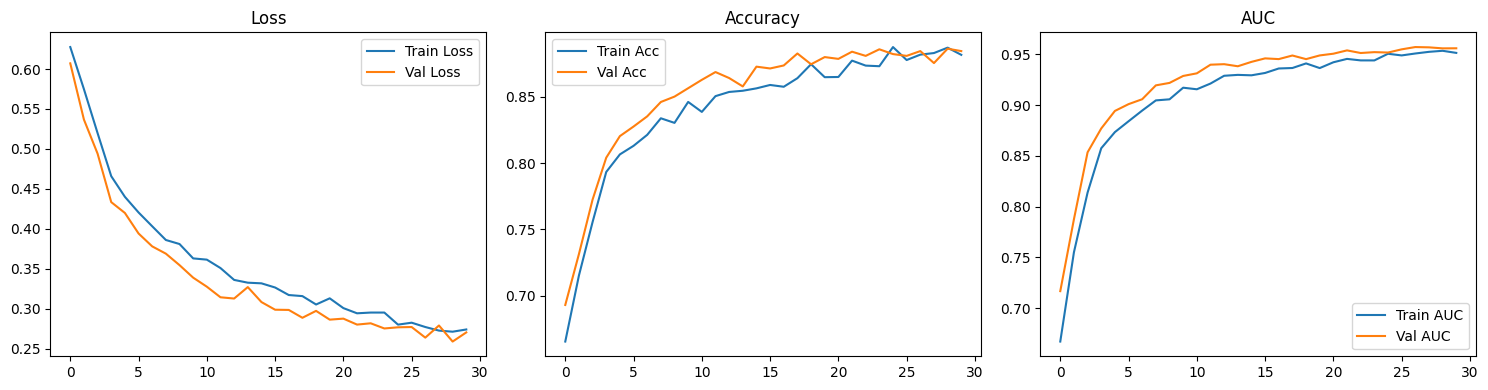


Final Results:
Train - Loss: 0.1979, Acc: 0.9302, AUC: 0.9846
Val   - Loss: 0.2640, Acc: 0.8847, AUC: 0.9573

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Control     0.9239    0.7978    0.8562       806
   Alcoholic     0.8924    0.9623    0.9260      1405

    accuracy                         0.9023      2211
   macro avg     0.9081    0.8800    0.8911      2211
weighted avg     0.9039    0.9023    0.9006      2211



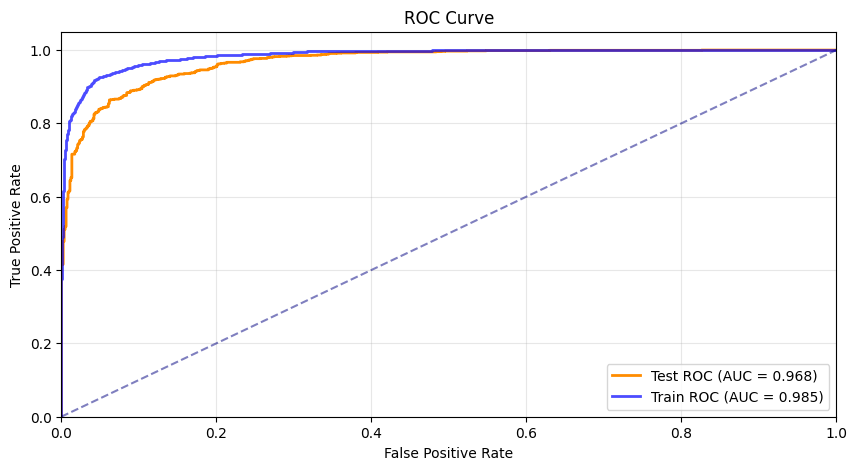

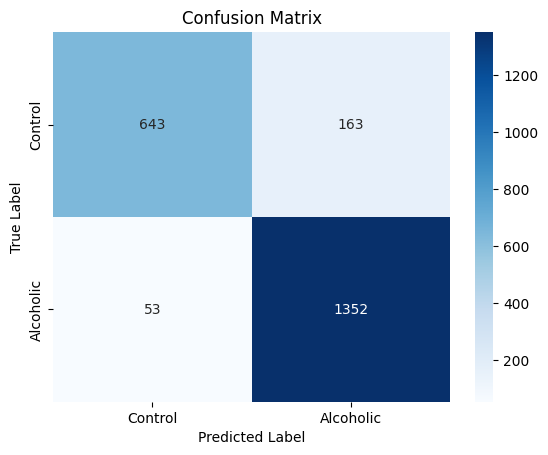

In [16]:
# ==== History ====
plot_training_history(history)

best_model = tf.keras.models.load_model('best_model.keras')
train_loss, train_acc, train_auc = best_model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc, val_auc = best_model.evaluate(X_val, y_val, verbose=0)
class_names = ['Control', 'Alcoholic']

print(f"\nFinal Results:")
print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f}")
print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUC: {val_auc:.4f}")

# ==== Predictions ====
y_pred_proba, y_pred = get_predictions(model, X_test)

if X_train is not None and y_train is not None:
    y_train_pred_proba, y_train_pred = get_predictions(model, X_train)

# ==== Report ====
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

# ==== ROC + CM ====
plot_roc_curves(y_test, y_pred_proba,
                y_train if X_train is not None else None,
                y_train_pred_proba if X_train is not None else None)

plot_confusion_matrix(y_test, y_pred, class_names)

# Save model

In [ ]:
model.save('/content/drive/My Drive/eegnet_alcoholism_model.keras')
print("Model saved!")